In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

[*********************100%***********************]  1 of 1 completed


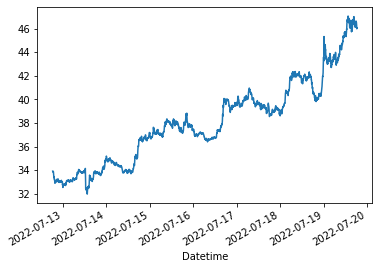

In [29]:
import yfinance as yf

# Get the data for the stock 
data = yf.download('SOL-USD','2022-07-13','2022-07-20', interval='1m')
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the close price
data['Close']
data['Close'].plot()
plt.show()

In [30]:
data.tail()

Open       High        Low      Close  \
Datetime                                                                
2022-07-19 18:19:00+00:00  46.008205  46.008205  46.008205  46.008205   
2022-07-19 18:20:00+00:00  46.025326  46.025326  46.025326  46.025326   
2022-07-19 18:25:00+00:00  46.073643  46.073643  46.073643  46.073643   
2022-07-19 18:28:00+00:00  46.096287  46.096287  46.096287  46.096287   
2022-07-19 18:29:00+00:00  46.076431  46.076431  46.076431  46.076431   

                           Adj Close   Volume  
Datetime                                       
2022-07-19 18:19:00+00:00  46.008205    52992  
2022-07-19 18:20:00+00:00  46.025326  1158656  
2022-07-19 18:25:00+00:00  46.073643  4632320  
2022-07-19 18:28:00+00:00  46.096287        0  
2022-07-19 18:29:00+00:00  46.076431        0

In [31]:
returns=data['Close'].pct_change()

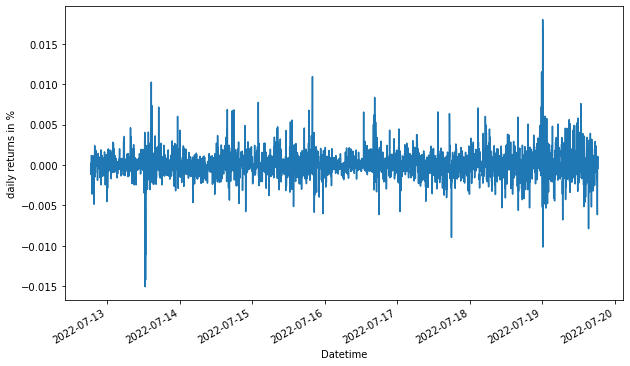

In [32]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    returns.plot(figsize=(10, 6))
    plt.ylabel("daily returns in %");

In [33]:
prior_coords = {'date': returns.index}

In [34]:
import pymc3 as pm

with pm.Model(coords=prior_coords) as SOLusd_model:
    # The model remembers the datetime index with the name 'date'
    change_returns = returns

    nu = pm.Exponential("nu", 1 / 10.0, testval=5.0)
    sigma = pm.Exponential("sigma", 2.0, testval=0.1)

    # We can now figure out the shape of variables based on the
    # index of the dataset
    s = pm.GaussianRandomWalk("s", sigma=sigma, dims='date')
    # instead of:
    # s = pm.GaussianRandomWalk('s', sigma, shape=len(returns))
    volatility_process = pm.Deterministic(
        "volatility_process", pm.math.exp(-2 * s) ** 0.5, dims='date'
    )

    r = pm.StudentT("r", nu=nu, sigma=volatility_process, observed=change_returns, dims='date')

/opt/miniconda3/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning:

Data in r contains missing values and will be automatically imputed from the sampling distribution.



In [35]:
with SOLusd_model:
    trace = pm.sample(2000, init="adapt_diag", return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r_missing, s, sigma, nu]
/opt/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2870 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


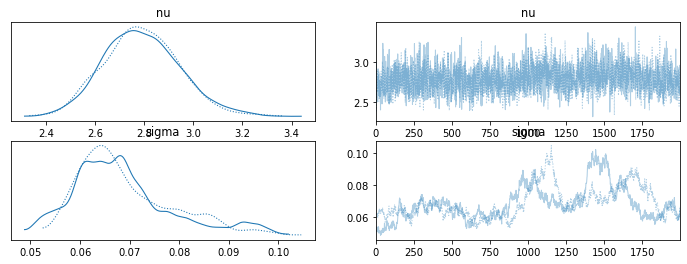

In [36]:
import arviz as az

with SOLusd_model:
    az.plot_trace(trace, var_names=["nu", "sigma"]);

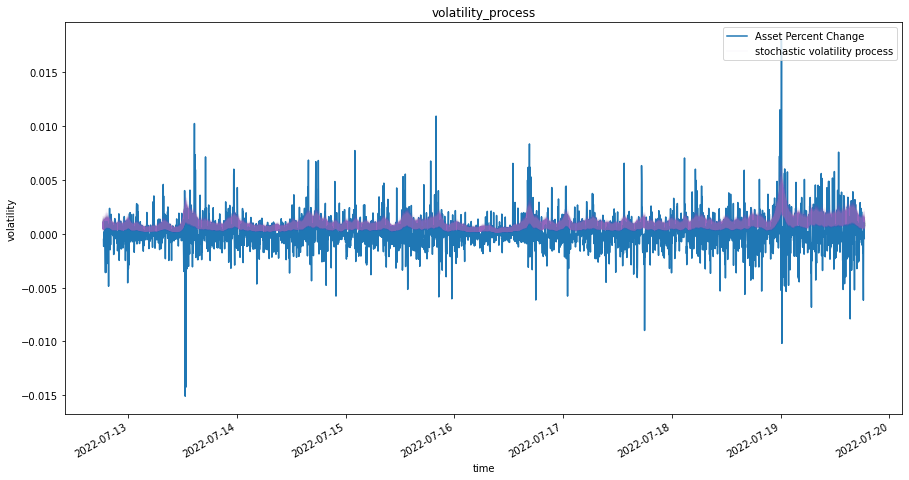

In [37]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1 / np.exp(trace["s", ::5].T), "C4", alpha=0.03)
ax.set(title="volatility_process", xlabel="time", ylabel="volatility")
ax.legend(["Asset Percent Change","stochastic volatility process"], loc="upper right")

In [38]:
stoch_vol=[np.mean(1/np.exp(trace["s", ::5].T)[i]) for i in np.arange(0,np.exp(trace["s", ::5].T).shape[0])]

In [39]:
dates=returns.index

In [40]:
dates.shape

(4772,)

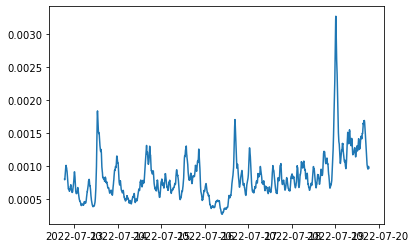

In [41]:
plt.plot(dates, stoch_vol)

In [42]:
dat={"ds":dates,"y":stoch_vol}

In [43]:
df=pd.DataFrame(dat)

In [44]:
df['ds']=df['ds'].dt.tz_localize(None)

In [61]:
#Conda installed Prophet, but had to import go module separately within the directory. 

from prophet import Prophet
m = Prophet()
m.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=600, freq='min')
df_predicted=m.predict(future)

08:42:01 - cmdstanpy - INFO - Chain [1] start processing
08:42:02 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
from prophet.plot import plot_plotly, plot_components_plotly
pred_plot = plot_plotly(m, df_predicted)
comp_plot = plot_components_plotly(m, df_predicted)

In [63]:
pred_plot

In [65]:
comp_plot